# Load our video file into memory

Welcome to foosbot

In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

In [ ]:
from __future__ import print_function


from video_file import *

import importlib
try:
    importlib.reload(video_file)
except:
    pass

import cv2
import sys
import os
import csv
import numpy as np
from random import randint
from random import shuffle

from PIL import Image
import imageio
import itertools as it

import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)


# Create the image transformer
transformer = VideoTransform( zoom_range=0.1, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [0,1,2,3,4,5], data_format='channels_last' )


# Paths relative to current python file.
data_path  = ".\\..\\..\\TrainingData\\Processed\\AmateurDefender\\Result\\settings.tsv"

In [1]:
print("Opening training frames from config %s." % (data_path))
position_rel_indexes = [0, 3] # Predict current rod positions and future position in 2 frames

number_of_frames = 1 # This is time it unwinds the LSTM back over
frame_rel_indexes = []
for i in range(number_of_frames):
    frame_rel_indexes += [i - number_of_frames + 1]

pp.pprint(frame_rel_indexes)
#frame_rel_indexes = [-4, -3, -2, -1, 0] # Use 5 frames as input


training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)
training.clear_memory()


Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0
Opening training frames from config .\..\..\TrainingData\Processed\AmateurDefender\Result\settings.tsv.
[0]
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk0.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk0.avi
added 15932 new frames for a total of 15932
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk1.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk1.avi
added 22943 new frames for a total of 38875
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk2.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk2.avi
added 11297 new frames for a total of 50172


In [6]:
# Define our training and validation iterators

image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = 3


def TrainGen(model, training):
    while True:
        #print("TrainGen restarting training input.")
        model.reset_states()
        training.move_first_training_frame()
        (frames, output, reset_memory) = training.get_next_training_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_training_frame()
            
            if reset_memory or frames is None:
                model.reset_states()
                
            
def ValidateGen(model, training):
    while True:
        #print("Validation restarting training input.")
        model.reset_states()
        training.move_first_validation_frame()
        (frames, output, reset_memory) = training.get_next_validation_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_validation_frame()
            
            if reset_memory or frames is None:
                model.reset_states()

# Generators for training the position
def TrainBatchGen(batch_size, model, training):
    gen = TrainGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0:3] # Train just the 3 current rod positions as outputs
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

def ValidateBatchGen(batch_size, model, training):
    gen = ValidateGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0:3] # Train just the 3 current rod positions as outputs
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
            
# Generators for training the difference in position
def TrainBatchGenDpos(batch_size, model, training):
    gen = TrainGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            
            # Decide if this dpos is valid by looking for a single frame position change > 0.1
            #max_dpos = 0.0
            #for i in range(len(batch_frames)/3):
            
            #batch_outputs[i,:] = output[0:3] # Train just the 3 current rod positions as outputs
            batch_outputs[i,0] = output[3] - output[0] # Train the difference in the three rod positions as output
            batch_outputs[i,1] = output[4] - output[1]
            batch_outputs[i,2] = output[5] - output[2]
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

def ValidateBatchGenDpos(batch_size, model, training):
    gen = ValidateGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            #batch_outputs[i,:] = output[0:3] # Train just the 3 current rod positions as outputs
            batch_outputs[i,0] = output[3] - output[0] # Train the difference in the three rod positions as output
            batch_outputs[i,1] = output[4] - output[1]
            batch_outputs[i,2] = output[5] - output[2]
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")


# Helper function to plot our validation result
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline


def plot_validate(generator, model, count, name):
    #plot_validate(ValidateBatchGen(batch_size, model), model, 2000, "Position prediction")
    
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    #(frames, outputs_true) = next(ValidateBatchGen(2000))
    #frames = np.squeeze(frames, axis=(1,))
    #validate_in, validate_out
    #frames = validate_in
    #outputs_true =validate_out
    
    print("Predicted.")
    
    
    pp.pprint(outputs_true)
    pp.pprint(outputs_predicted)
    
    
    plt.figure(figsize=(8,30))
    
    plt.subplot(611)
    plt.plot(range(count),outputs_true[0:count,0], range(count),outputs_predicted[0:count,0] )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(612)
    plt.plot(range(count),outputs_true[0:count,1], range(count),outputs_predicted[0:count,1] )
    plt.ylabel("Rod 2: %s" % name)
    plt.title("First output recordings")
    plt.grid(True)
    
    plt.subplot(613)
    plt.plot(range(count),outputs_true[0:count,2], range(count),outputs_predicted[0:count,2] )
    plt.ylabel("Rod 3: %s" % name)
    plt.title("First output recordings")
    plt.grid(True)
    
    
    
    plt.figure(figsize=(8,30))
    plt.subplot(611)
    
    true, predicted = zip(*sorted(zip(outputs_true[0:count,0], outputs_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(612)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,1], outputs_predicted[0:count,1])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 2: %s" % name)
    plt.grid(True)
    
    plt.subplot(613)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,2], outputs_predicted[0:count,2])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 3: %s" % name)
    plt.grid(True)
    
    
    plt.show()
          


# Input training frame

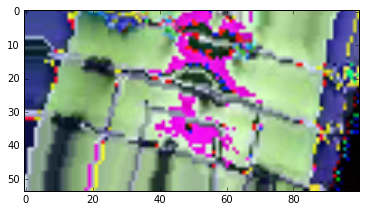

[0.4303030303030303,
 0.1680327868852459,
 0.22162162162162163,
 0.4303030303030303,
 0.1680327868852459,
 0.22162162162162163]


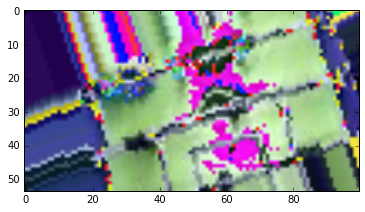

[0.4303030303030303,
 0.1680327868852459,
 0.22162162162162163,
 0.4303030303030303,
 0.1680327868852459,
 0.22702702702702704]


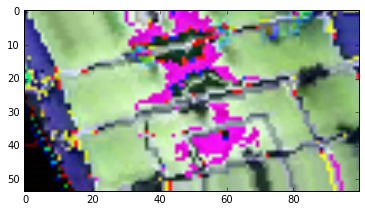

[0.5696969696969697,
 0.8319672131147541,
 0.7783783783783784,
 0.5696969696969697,
 0.8319672131147541,
 0.772972972972973]


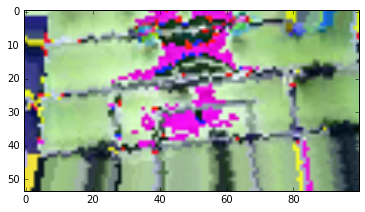

[0.5696969696969697,
 0.8319672131147541,
 0.7783783783783784,
 0.5696969696969697,
 0.8319672131147541,
 0.772972972972973]


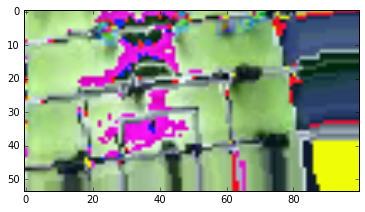

[0.5696969696969697,
 0.8319672131147541,
 0.772972972972973,
 0.5696969696969697,
 0.8319672131147541,
 0.772972972972973]


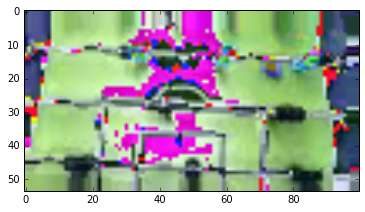

[0.5696969696969697,
 0.8319672131147541,
 0.772972972972973,
 0.5696969696969697,
 0.8319672131147541,
 0.772972972972973]


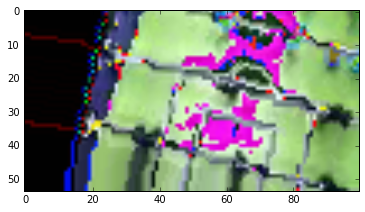

[0.5696969696969697,
 0.8319672131147541,
 0.772972972972973,
 0.5696969696969697,
 0.8319672131147541,
 0.772972972972973]


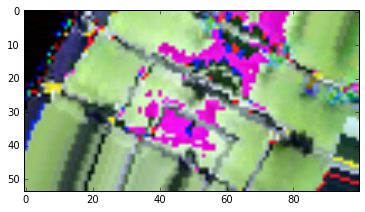

[0.5696969696969697,
 0.8319672131147541,
 0.772972972972973,
 0.5696969696969697,
 0.8319672131147541,
 0.772972972972973]


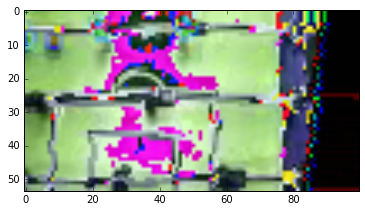

[0.4303030303030303,
 0.16803278688524592,
 0.22702702702702704,
 0.4303030303030303,
 0.16803278688524592,
 0.22162162162162158]


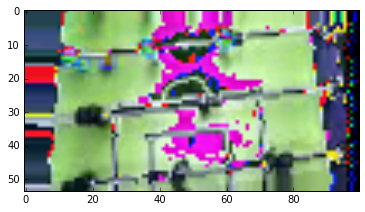

[0.4303030303030303,
 0.16803278688524592,
 0.22702702702702704,
 0.4303030303030303,
 0.17622950819672134,
 0.22162162162162158]
Shape of training input:
(1, 54, 100, 3)
Shape of training output:
(6,)
Corresponding Positions:
[0.4303030303030303,
 0.16803278688524592,
 0.22702702702702704,
 0.4303030303030303,
 0.17622950819672134,
 0.22162162162162158]


In [4]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline

training.move_first_training_frame()

for k in range(10):
    (frame, position, reset) = training.get_next_training_frame()
    data = np.zeros(shape=(np.shape(frame)[1], np.shape(frame)[2] * np.shape(frame)[0], 3), dtype=np.float32)
    for i in range(np.shape(frame)[0]):
        tmp = frame[i,:,:,:]
        data[:,i*np.shape(frame)[2]:(i+1)*np.shape(frame)[2],:] = tmp


    plt.imshow(data)
    plt.show()
    pp.pprint(position)

training.move_first_training_frame()

print("Shape of training input:")
pp.pprint(np.shape(frame))

print("Shape of training output:")
pp.pprint(np.shape(position))

print("Corresponding Positions:")
pd.DataFrame(position)
pp.pprint(position)




# Specify the model structure we will use

In [3]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model




# Model options
batch_size = 40
lstm_output_size = 300
cnn_kernel_count = 120

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_depth, image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

# Build a functional model design
inputs = Input(shape=(number_of_frames, image_height, image_width, image_channels,),
               batch_shape=(batch_size, number_of_frames, image_height, image_width, image_channels),
              name="Input")
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 1, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1




#x = Flatten()(x)
x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)

#x = keras.layers.concatenate([x_height_detailed, x_width_detailed])

x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)

#LSTM layer is only used when predicting the future position
#x = LSTM(lstm_output_size, activation='relu', dropout=0.2, recurrent_dropout=0.2, stateful=True)(x)
x = Flatten()(x)

x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(3, activation='linear',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=['accuracy'])


model.summary()


'Input shape without batches:'
(1, 54, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (40, 1, 54, 100, 3)       0         
_________________________________________________________________
conv3d_0 (Conv3D)            (40, 1, 54, 100, 120)     3360      
_________________________________________________________________
conv3d_1 (Conv3D)            (40, 1, 54, 100, 120)     129720    
_________________________________________________________________
max_pooling3d_0 (MaxPooling3 (40, 1, 27, 50, 120)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (40, 1, 27, 50, 120)      129720    
_________________________________________________________________
conv3d_3 (Conv3D)            (40, 1, 27, 50, 120)      129720    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 

# Train our model to identify the rod positions

In [6]:


def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = 'pos_cnn_weights_%i.hdf'
MODELS_FNAME = 'pos_cnn_models_%i.h5'


batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )

model.reset_states()
for epoch in range(1000):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break
    

Updated learner.
Batch size 40: 1003 training batches, 250 validation batches
Epoch 1/1
1002/1003 [============================>.] - ETA: 0s - loss: 0.1019 - mse: 1.0190e-04

Exception in thread Thread-21:
Traceback (most recent call last):
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\keras\engine\training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-3-2a4805d976d0>", line 45, in TrainBatchGen
    (frames, output) = next(gen)
  File "<ipython-input-3-2a4805d976d0>", line 14, in TrainGen
    training.move_first_training_frame()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", line 399, in move_first_training_frame
    self.chunks[0].move_first_training_frame()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", line 124, in move_first_training_frame
    self._load_video_memory()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", l

1003/1003 [==============================] - 332s - loss: 0.1019 - mse: 1.0186e-04 - val_loss: 0.0606 - val_mse: 6.0586e-05
Wrote model to pos_cnn_weights_0.hdf
Epoch 2/2
1002/1003 [============================>.] - ETA: 0s - loss: 0.0556 - mse: 5.5642e-05

Exception in thread Thread-23:
Traceback (most recent call last):
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\keras\engine\training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-3-2a4805d976d0>", line 45, in TrainBatchGen
    (frames, output) = next(gen)
  File "<ipython-input-3-2a4805d976d0>", line 14, in TrainGen
    training.move_first_training_frame()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", line 399, in move_first_training_frame
    self.chunks[0].move_first_training_frame()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", line 124, in move_first_training_frame
    self._load_video_memory()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", l

1003/1003 [==============================] - 358s - loss: 0.0557 - mse: 5.5661e-05 - val_loss: 0.0551 - val_mse: 5.5077e-05
Wrote model to pos_cnn_weights_1.hdf
Epoch 3/3
1003/1003 [==============================] - 352s - loss: 0.0526 - mse: 5.2568e-05 - val_loss: 0.0518 - val_mse: 5.1825e-05
Wrote model to pos_cnn_weights_2.hdf
Epoch 4/4
  19/1003 [..............................] - ETA: 806s - loss: 0.0184 - mse: 1.8425e-05
User stopped the training.


# Test the best trained model's ability to extract the rod positions

In [7]:

# Load the best model result
epoch = 2
WEIGHTS_FNAME = 'pos_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")



Loaded model.


Predicted.
array([[ 0.30303031,  0.46311477,  0.58918917],
       [ 0.32727271,  0.46311477,  0.58918917],
       [ 0.34545454,  0.46721312,  0.60540539],
       ..., 
       [ 0.58787876,  0.68032789,  0.08108108],
       [ 0.58181816,  0.67622954,  0.08108108],
       [ 0.58181816,  0.67622954,  0.08108108]], dtype=float32)
array([[ 0.49222061,  0.41609737,  0.490244  ],
       [ 0.4943665 ,  0.42227599,  0.49137783],
       [ 0.50606859,  0.45470369,  0.49536017],
       ..., 
       [ 0.54711121,  0.58874345,  0.5128901 ],
       [ 0.54917431,  0.59698439,  0.51405805],
       [ 0.56418574,  0.66136563,  0.52131587]], dtype=float32)


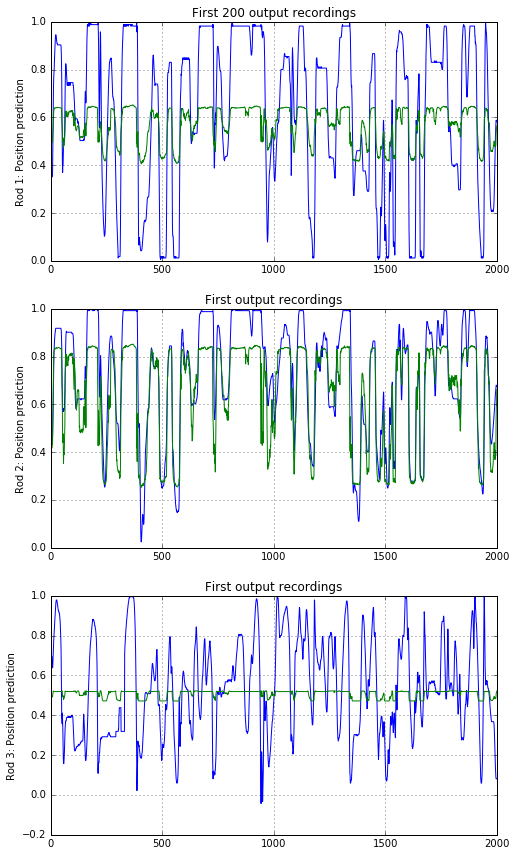

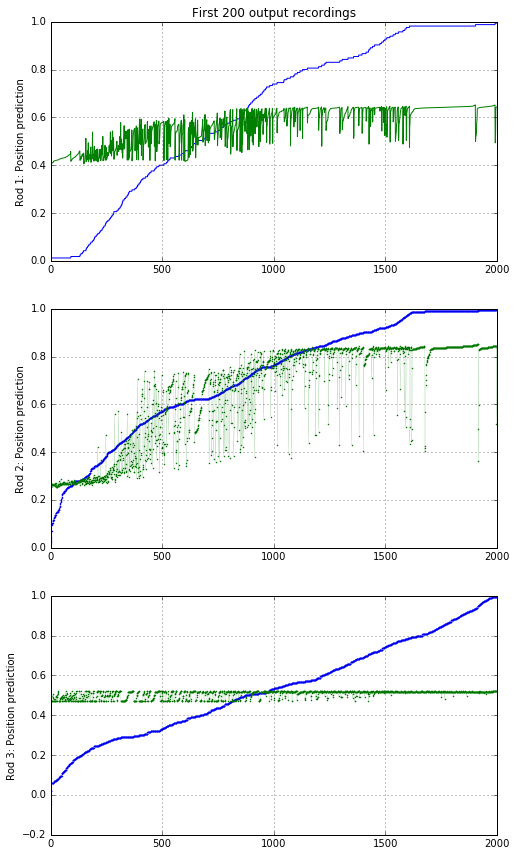

In [8]:
# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model), model, 2000, "Position prediction")

# Transfer the model as a base to predict the future change in rod positions
The theory is that the model has designed filters that are able to successfully extract the rod positions. This is important information needed to make a good decision on how the rods should be moved. We take this base model which has learned how to track the rod positions as a base for the real AI that predicts the rod movements that are going to occur next.


In [4]:
print("Opening training frames from config %s." % (data_path))
position_rel_indexes = [0, 3] # Predict current rod positions and future position in 2 frames

number_of_frames = 10 # This is time it unwinds the LSTM back over
frame_rel_indexes = []
for i in range(number_of_frames):
    frame_rel_indexes += [i - number_of_frames + 1]

pp.pprint(frame_rel_indexes)
#frame_rel_indexes = [-4, -3, -2, -1, 0] # Use 5 frames as input


training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)
training.clear_memory()

Opening training frames from config .\..\..\TrainingData\Processed\AmateurDefender\Result\settings.tsv.
[-9, -8, -7, -6, -5, -4, -3, -2, -1, 0]
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk0.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk0.avi
added 15932 new frames for a total of 15932
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk1.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk1.avi
added 22943 new frames for a total of 38875
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk2.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk2.avi
added 11297 new frames for a total of 50172


In [5]:

# Achitecture for predicting the next position
from keras.models import Sequential
from keras.layers import *
from keras.models import Model

# Model options
batch_size = 5
lstm_output_size = 300

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_depth, image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

# Build a functional model design
inputs = Input(shape=(number_of_frames, image_height, image_width, image_channels,),
               batch_shape=(batch_size, number_of_frames, image_height, image_width, image_channels))
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 1, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1




#x = Flatten()(x)
x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)

#x = keras.layers.concatenate([x_height_detailed, x_width_detailed])

x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)

#LSTM layer is only used when predicting the future position
x = LSTM(lstm_output_size, activation='relu', dropout=0.2, recurrent_dropout=0.2)(x)

x = Dense(128, activation='relu',name="dd")(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(3, activation='linear',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=['accuracy'])


model.summary()

'Input shape without batches:'
(1, 54, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (5, 10, 54, 100, 3)       0         
_________________________________________________________________
conv3d_0 (Conv3D)            (5, 10, 54, 100, 120)     3360      
_________________________________________________________________
conv3d_1 (Conv3D)            (5, 10, 54, 100, 120)     129720    
_________________________________________________________________
max_pooling3d_0 (MaxPooling3 (5, 10, 27, 50, 120)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (5, 10, 27, 50, 120)      129720    
_________________________________________________________________
conv3d_3 (Conv3D)            (5, 10, 27, 50, 120)      129720    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 

In [6]:
# Load the best model result
epoch = 2
WEIGHTS_FNAME = 'pos_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")




Loaded model.


In [10]:
def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = 'dpos_cnn_weights_%i.hdf'
MODELS_FNAME = 'dpos_cnn_models_%i.h5'


batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("%i training batches, %i validation batches" % (batches_training_per_epoch, batches_validation_per_epoch) )

for epoch in range(1000):
    try:
        model.fit_generator(TrainBatchGenDpos(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGenDpos(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break
    

Updated learner.
8027 training batches, 2006 validation batches
Epoch 1/1
8027/8027 [==============================] - 3306s - loss: 0.0188 - mse: 1.8841e-05 - val_loss: 0.0057 - val_mse: 5.6635e-06
Wrote model to dpos_cnn_weights_0.hdf
Epoch 2/2
8027/8027 [==============================] - 3302s - loss: 0.0071 - mse: 7.0839e-06 - val_loss: 0.0055 - val_mse: 5.4695e-06
Wrote model to dpos_cnn_weights_1.hdf
Epoch 3/3
8027/8027 [==============================] - 3301s - loss: 0.0064 - mse: 6.4488e-06 - val_loss: 0.0054 - val_mse: 5.4381e-06
Wrote model to dpos_cnn_weights_2.hdf
Epoch 4/4
8027/8027 [==============================] - 3301s - loss: 0.0063 - mse: 6.2776e-06 - val_loss: 0.0055 - val_mse: 5.5181e-06
Wrote model to dpos_cnn_weights_3.hdf
Epoch 5/5
8027/8027 [==============================] - 3300s - loss: 0.0062 - mse: 6.1944e-06 - val_loss: 0.0053 - val_mse: 5.2993e-06
Wrote model to dpos_cnn_weights_4.hdf
Epoch 6/6
8027/8027 [==============================] - 3296s - loss: 0.

Loaded model.
Predicted.
array([[ 0.27878788,  0.18032786,  0.08108108],
       [ 0.27878788,  0.2090164 ,  0.09189189],
       [ 0.21212122,  0.20491803,  0.08648649],
       ..., 
       [ 0.00606061,  0.0204918 ,  0.        ],
       [-0.02424242, -0.00819672,  0.        ],
       [-0.06060606, -0.04918033,  0.        ]], dtype=float32)
array([[ 0.00133859,  0.00380038,  0.00143599],
       [ 0.00717875,  0.01143159,  0.0054639 ],
       [ 0.01310897,  0.01815805,  0.0087241 ],
       ..., 
       [ 0.00045246,  0.00041318,  0.00026414],
       [ 0.00202435,  0.00217886,  0.00101059],
       [ 0.0036953 ,  0.00407629,  0.00179549]], dtype=float32)


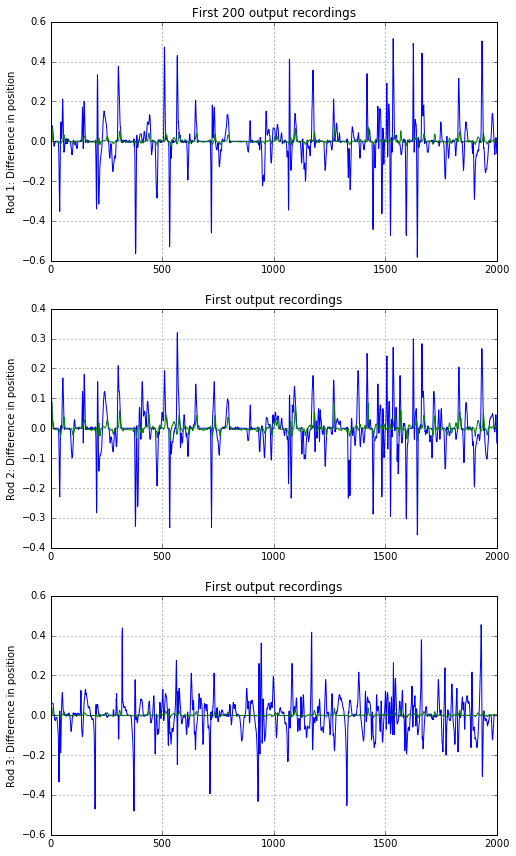

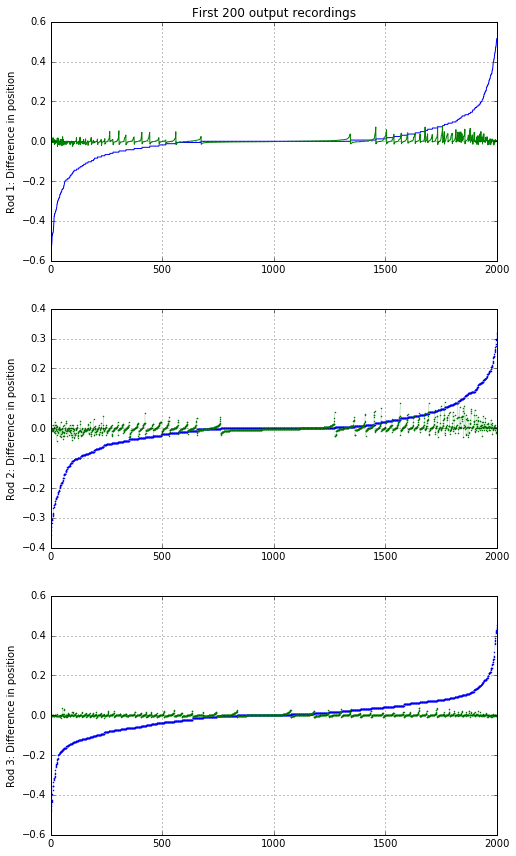

In [11]:
# Load the best position prediction model as the starting point
epoch = 16
WEIGHTS_FNAME = 'dpos_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch)
print("Loaded model.")


# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGenDpos(batch_size, model, training), model, 2000, "Difference in position")

In [12]:
def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00001),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = 'dpos_cnn_weights_%i.hdf'
MODELS_FNAME = 'dpos_cnn_models_%i.h5'

start_epoch = epoch+1

batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("%i training batches, %i validation batches" % (batches_training_per_epoch, batches_validation_per_epoch) )

for epoch in range(1000):
    try:
        model.fit_generator(TrainBatchGenDpos(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGenDpos(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break
    

Updated learner.
8027 training batches, 2006 validation batches
Epoch 1/1
8027/8027 [==============================] - 3309s - loss: 0.0063 - mse: 6.2854e-06 - val_loss: 0.0054 - val_mse: 5.4036e-06
Wrote model to dpos_cnn_weights_0.hdf
Epoch 2/2
8027/8027 [==============================] - 3304s - loss: 0.0062 - mse: 6.2230e-06 - val_loss: 0.0054 - val_mse: 5.3844e-06
Wrote model to dpos_cnn_weights_1.hdf
Epoch 3/3
8027/8027 [==============================] - 3305s - loss: 0.0062 - mse: 6.1631e-06 - val_loss: 0.0054 - val_mse: 5.3594e-06
Wrote model to dpos_cnn_weights_2.hdf
Epoch 4/4
8027/8027 [==============================] - 3305s - loss: 0.0061 - mse: 6.1456e-06 - val_loss: 0.0053 - val_mse: 5.3147e-06
Wrote model to dpos_cnn_weights_3.hdf
Epoch 5/5
8027/8027 [==============================] - 5746s - loss: 0.0061 - mse: 6.0585e-06 - val_loss: 0.0053 - val_mse: 5.2914e-06
Wrote model to dpos_cnn_weights_4.hdf
Epoch 6/6
2200/8027 [=======>......................] - ETA: 5594s - los

In [7]:
# Load the best position prediction model as the starting point
epoch = 33
WEIGHTS_FNAME = 'dpos_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch)
print("Loaded model.")

Loaded model.


Predicted.
array([[ 0.27878788,  0.18032786,  0.08108108],
       [ 0.27878788,  0.2090164 ,  0.09189189],
       [ 0.21212122,  0.20491803,  0.08648649],
       ..., 
       [ 0.00606061,  0.0204918 ,  0.        ],
       [-0.02424242, -0.00819672,  0.        ],
       [-0.06060606, -0.04918033,  0.        ]], dtype=float32)
array([[ 0.00738869,  0.00932999,  0.00377875],
       [ 0.01491626,  0.02148345,  0.00793287],
       [ 0.01879618,  0.02773587,  0.01007175],
       ..., 
       [ 0.03814369,  0.05861424,  0.02062855],
       [ 0.04008378,  0.06163727,  0.02161472],
       [ 0.03599751,  0.05505423,  0.01933355]], dtype=float32)


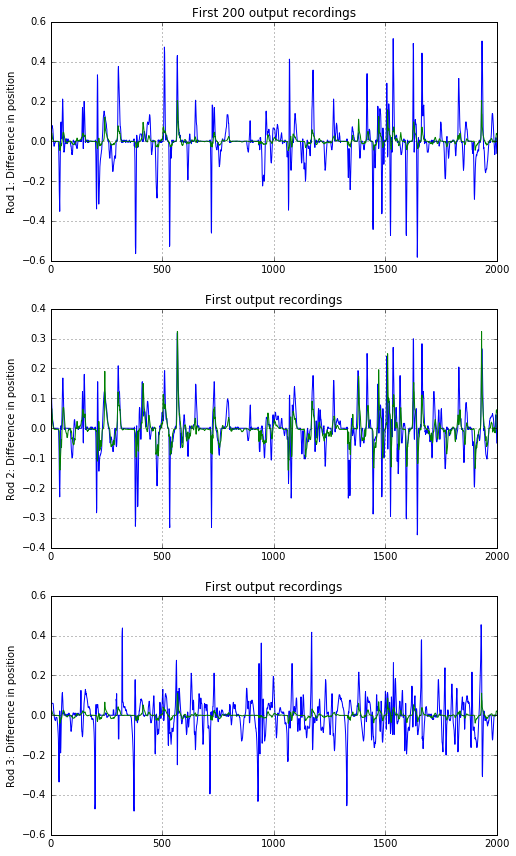

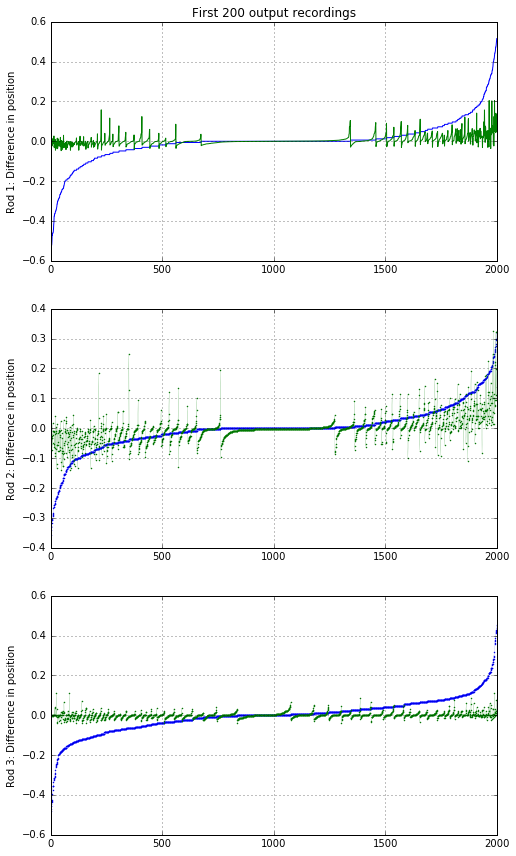

In [8]:



# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGenDpos(batch_size, model, training), model, 2000, "Difference in position")

In [9]:
def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00001),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = 'dpos_cnn_weights_%i.hdf'
MODELS_FNAME = 'dpos_cnn_models_%i.h5'

start_epoch = epoch+1

batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("%i training batches, %i validation batches" % (batches_training_per_epoch, batches_validation_per_epoch) )

for epoch in range(start_epoch,1000):
    try:
        model.fit_generator(TrainBatchGenDpos(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGenDpos(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break

Updated learner.
8027 training batches, 2006 validation batches
Epoch 35/35
8027/8027 [==============================] - 3295s - loss: 0.0057 - mse: 5.6807e-06 - val_loss: 0.0048 - val_mse: 4.8204e-06
Wrote model to dpos_cnn_weights_34.hdf
Epoch 36/36
8027/8027 [==============================] - 3294s - loss: 0.0057 - mse: 5.6744e-06 - val_loss: 0.0048 - val_mse: 4.8128e-06
Wrote model to dpos_cnn_weights_35.hdf
Epoch 37/37
8027/8027 [==============================] - 3289s - loss: 0.0057 - mse: 5.6629e-06 - val_loss: 0.0048 - val_mse: 4.8150e-06
Wrote model to dpos_cnn_weights_36.hdf
Epoch 38/38
8027/8027 [==============================] - 3291s - loss: 0.0057 - mse: 5.6576e-06 - val_loss: 0.0048 - val_mse: 4.8081e-06
Wrote model to dpos_cnn_weights_37.hdf
Epoch 39/39
8027/8027 [==============================] - 3291s - loss: 0.0056 - mse: 5.6500e-06 - val_loss: 0.0048 - val_mse: 4.7867e-06
Wrote model to dpos_cnn_weights_38.hdf
Epoch 40/40
8027/8027 [==============================] -

Loaded model.
Predicted.
array([[ 0.27878788,  0.18032786,  0.08108108],
       [ 0.27878788,  0.2090164 ,  0.09189189],
       [ 0.21212122,  0.20491803,  0.08648649],
       ..., 
       [ 0.00606061,  0.0204918 ,  0.        ],
       [-0.02424242, -0.00819672,  0.        ],
       [-0.06060606, -0.04918033,  0.        ]], dtype=float32)
array([[ 0.01964831,  0.02626742,  0.00933846],
       [ 0.02580084,  0.03508758,  0.01231509],
       [ 0.02992106,  0.04099144,  0.01431   ],
       ..., 
       [ 0.04063605,  0.056362  ,  0.0194897 ],
       [ 0.04389086,  0.06100101,  0.02104606],
       [ 0.04152462,  0.05760285,  0.01988394]], dtype=float32)


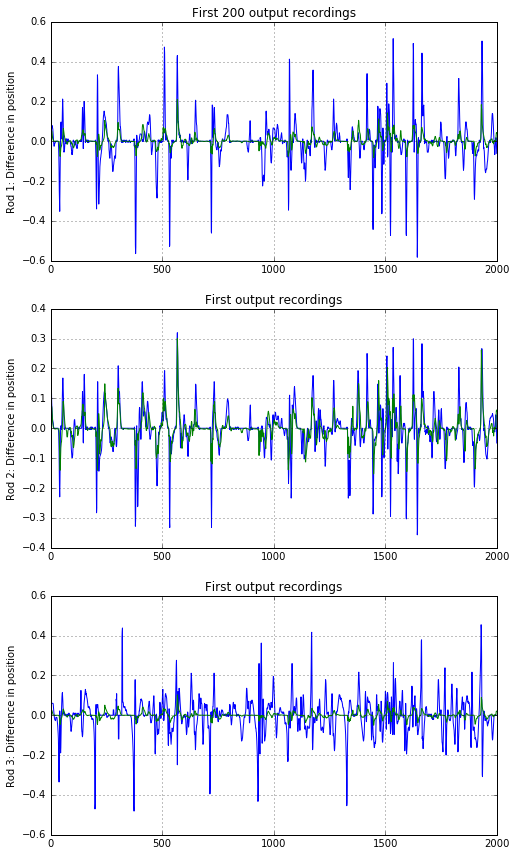

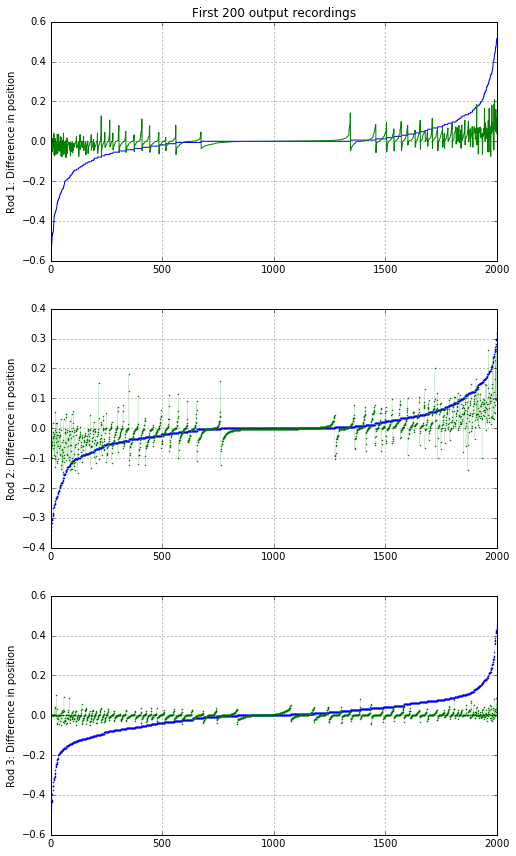

In [10]:
# Load the best position prediction model as the starting point
epoch = 47
WEIGHTS_FNAME = 'dpos_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch)
print("Loaded model.")


# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGenDpos(batch_size, model, training), model, 2000, "Difference in position")